# Backward Engineering 538 model

**538** for a third consecutive election had one of the best prediction models, consistently giving Trump better odds than most forecast models. To their credit, they are very transparent about their methodology, which allows us to attempt to recreate some of what they do. In this model I will try to incorporate the most imporant elements.

http://fivethirtyeight.com/features/a-users-guide-to-fivethirtyeights-2016-general-election-forecast/

**Notes**

- Fat tails from a students t distribution, 10 degrees of freedom
- The direction and degree to which states error is correlated
- Adjusted polls will be used
- Not accounting for trend lines or strength of poll.

In [12]:
import pandas as pd # linear algebra
import numpy as np
import matplotlib.pyplot as plt

polls = pd.read_csv("https://raw.githubusercontent.com/rajeevratan84/data-analyst-bootcamp/master/presidential_polls.csv",
                    usecols = ["state","startdate","adjpoll_clinton","adjpoll_trump"], parse_dates = ["startdate"], 
                    infer_datetime_format = "TRUE" )
polls.head()

,state,startdate,adjpoll_clinton,adjpoll_trump
0,U.S.,2016-10-25,42.64140,40.86509
1,U.S.,2016-10-27,43.29659,44.72984
2,Virginia,2016-10-27,46.29779,40.72604
3,Florida,2016-10-20,46.35931,45.30585
4,U.S.,2016-10-20,45.32744,42.20888


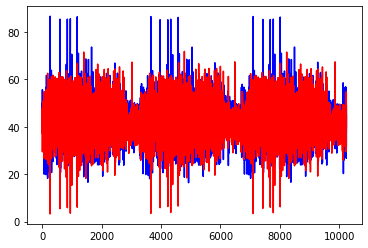

In [17]:
x = polls['startdate']
plt.plot(polls.index, polls['adjpoll_clinton'], color="blue")
plt.plot(polls.index, polls['adjpoll_trump'], color="red")

Given that I only have correlations for 15 states, that is all I will be modeling. We need a way to randomly sample from a t distribution in order to account for possible errors in all 15 states, while taking into account that these are not independent variables.

Correlation data taken from: http://fivethirtyeight.com/features/election-update-maybe-its-time-for-ohio-and-pennsylvania-to-part-ways/



In [3]:
states = ["Maine","New Hampshire","Pennsylvania","Ohio","Michigan","Wisconsin","Minnesota","Iowa","Colorado","Nevada","Arizona","Virginia","North Carolina","Georgia","Florida"]
votes = [4,4,20,18,16,10,10,6,9,6,11,13,15,16,29]
# Clinton has 187, Trump has 164 in remaining states
corr = np.zeros((15,15))


# From link above
corr[0,] = (0,0.58,0.46,0.61,0.61,0.63,0.57,0.63,0.56,0.53,0.56,0.44,0.43,0.37,0.55)
corr[1,] = (0,0,0.53,0.63,0.64,0.69,0.64,0.7,0.71,0.57,0.64,0.57,0.46,0.39,0.62)
corr[2,] = (0,0,0,0.64,0.61,0.62,0.72,0.56,0.61,0.48,0.64,0.57,0.46,0.39,0.62)
corr[3,] = (0,0,0,0,.9,.86,.81,.84,.57,.67,.65,.48,.59,.53,.62)
corr[4,] = (0,0,0,0,0,0.86,0.79,0.83,0.57,0.68,0.67,0.46,0.55,0.51,0.65)
corr[5,] = (0,0,0,0,0,0,0.8,0.84,0.63,0.66,0.66,0.5,0.51,0.45,0.66)
corr[6,] = (0,0,0,0,0,0,0,0.78,0.66,0.55,0.58,0.6,0.57,0.49,0.56)
corr[7,] = (0,0,0,0,0,0,0,0,0.67,0.65,0.67,0.53,0.53,0.54,0.66)
corr[8,] = (0,0,0,0,0,0,0,0,0,0.62,0.76,0.76,0.57,0.52,0.63)
corr[9,] = (0,0,0,0,0,0,0,0,0,0,0.8,0.43,0.46,0.49,0.64)
corr[10,] = (0,0,0,0,0,0,0,0,0,0,0,0.55,0.50,0.52,0.66)
corr[11,] = (0,0,0,0,0,0,0,0,0,0,0,0,0.77,0.73,0.67)
corr[12,] = (0,0,0,0,0,0,0,0,0,0,0,0,0,0.81,0.64)
corr[13,] = (0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.61)

statescorr = []
# Building correlation matrix between states
statescorr = corr + np.matrix.transpose(corr) + np.identity(15)

# Calculation Std Dev of each states polls    
statestd = [] 
for s in states:
    pollstd = []
    pollstd = (polls["state"] == s)
    statestd.append(np.std(polls[pollstd].adjpoll_clinton))

# Make a convariance matrix from the correlation matrix  
statecov = statescorr
for i in range(len(states)):
    for j in range(len(states)):
        statecov[i,j] = statescorr[i,j] * statestd[i] * statestd[j]

In [4]:
#This function will generate random variables with students t, 10 degrees of freedom, and correlated as above
#http://stackoverflow.com/questions/29798795/multivariate-student-t-distribution-with-python
def multivariatet(mu,Sigma,N,M):
    d = len(Sigma)
    g = np.tile(np.random.gamma(N/2.,2./N,M),(d,1)).T
    Z = np.random.multivariate_normal(np.zeros(d),Sigma,M)
    return mu + Z/np.sqrt(g)

In [5]:
#Taking average of all polls in the last month, each week and then finding difference
difference = []
for s in states:
    row = []
    for i in pd.date_range("2016-06-01","2016-11-01",freq = "W"):
          pollselect = []
          pollselect = (polls["state"] == s) & (polls["startdate"] <= i) & (polls["startdate"] >= i -pd.DateOffset(month = 1))
          row.append(np.nanmean(polls[pollselect].adjpoll_clinton)- np.nanmean(polls[pollselect].adjpoll_trump))
    difference.append(row)

Here the average of all polls in a given state in the last month were averaged to generate a good starting point to apply error to.

In [6]:
#40000 Simulations
#200 state errors X 200 national errors
#Adding the errors to each state's polling average
#Seeing in how many simulations Clinton gets the 83 votes to win

#Degrees of Freedom
df = 10

clinton = []
trump = []
clintonblow = []
trumpblow = []
for m in range(len(difference[1])):
    clintonodds = 0
    cblowout = 0
    tblowout = 0
    for i in range(200):
        state = multivariatet(0,statecov, df, 200)
        national = np.random.standard_t(10,200)
        for n in range(len(national)):
            count = 0
            for s in range(len(states)):
                if (national[n] + difference[s][m] + state[i][s]) > 0:
                    count = count + votes[s]
            if count > 82:
                clintonodds = clintonodds + 0.000025
            if count == 0:
                tblowout = tblowout + 0.000025
            if count == 187:
                cblowout = cblowout + 0.000025
    clinton.append(clintonodds)
    trump.append(1-clintonodds)
    clintonblow.append(cblowout)
    trumpblow.append(tblowout)

Data actually turned out to be reasonable approximation of what 538 was getting and more optimistic for Trump than most models were.

No handles with labels found to put in legend.


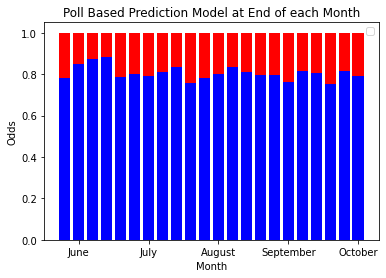

In [18]:
x = ["June","July","August","September","October"]
fig, ax = plt.subplots()
rects1 = ax.bar(range(22), clinton, color='b')
rects2 = ax.bar(range(22), trump, bottom = clinton, color = 'r')

plt.title("Poll Based Prediction Model at End of each Month")

ax.set_ylabel('Odds')
ax.set_xlabel('Month')
ax.set_xticks((1,6,11,16,21))
ax.set_xticklabels((x))
ax.legend()

(0.9, 22.1, -1e-05, 0.07)

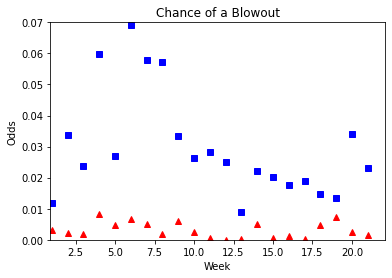

In [11]:
yt = trumpblow
yc = clintonblow
dummy = range(22)
plt.plot(dummy , yt, 'r^', dummy, yc, 'bs', linewidth=2.0)

plt.title("Chance of a Blowout")
plt.ylabel('Odds')
plt.xlabel('Week')
plt.axis([0.9,22.1,-0.00001,0.07])

The blowout probabilities are very noisy, whereas the prediction of the winner moves a little bit less than most models. This is due to averaging a months worth of polls, so the change needs to be dramatic or sustained to be seen in the model.

This model deliberately does not take into account many factors, but I still think it produces decent output. To improve it should take into account the grade of each pollster, weight polls by time, incorporate national polling data into the model, and change depending on how close the election is.